In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm  # Use standard tqdm instead of notebook version

import keras
from keras import backend as K
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random
from PIL import Image

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.models import Model
import struct
from copy import deepcopy
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet import MobileNet

from hypopt import GridSearch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import cv2

import requests, io, zipfile

2024-05-30 22:19:30.566746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 22:19:32.211569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/vishnuaa77/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/vishnuaa77/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn

In [3]:
metadata_path = 'data/raw/metadata.csv'
images_rgb_path = 'data/raw/hmnist_8_8_RGB.csv'

IMG_WIDTH = 100
IMG_HEIGHT = 75

X = []
X_gray = []

y = []

In [4]:
metadata = pd.read_csv(metadata_path)
metadata['category'] = metadata['dx'].replace({'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6,})

im_path = "data/raw/images_all"

for i in tqdm(range(len(metadata))):
  image_meta = metadata.iloc[i]
  path = os.path.join(im_path, image_meta['image_id'] + '.jpg')
  img = cv2.imread(path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))

  img_g = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  X_gray.append(img_g)

  X.append(img)
  y.append(image_meta['category'])

X_gray = np.array(X_gray)
X = np.array(X)
y = np.array(y)

100%|██████████| 10015/10015 [01:16<00:00, 130.63it/s]


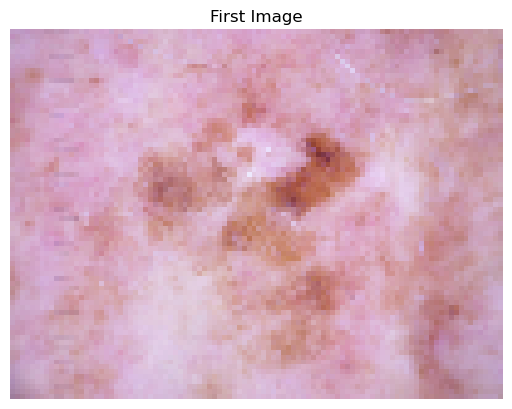

In [8]:
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title('First Image')
plt.axis('off')  # Hide axis
plt.show()

In [9]:
print(X_gray.shape)
print(X.shape)
print(y.shape)

(10015, 75, 100)
(10015, 75, 100, 3)
(10015,)


[327, 514, 1099, 115, 1113, 6705, 142]


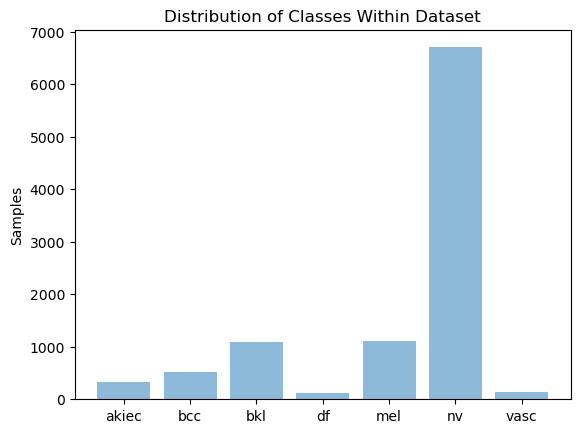

In [10]:
objects = ('akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc')
y_pos = np.arange(len(objects))
occurances = []

for obj in objects:
  occurances.append(np.count_nonzero(obj == metadata['dx']))

print(occurances)

plt.bar(y_pos, occurances, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Samples')
plt.title('Distribution of Classes Within Dataset')

plt.show()

## Balancing Dataset

In [11]:
objects = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
class_totals = [0, 0, 0, 0, 0, 0, 0]

for i in range(len(X)):
    class_totals[y[i]] += 1

print("Initial Class Samples")
print(class_totals)

largest_index = class_totals.index(max(class_totals))
class_totals[largest_index] = 0

# Find the second largest value
second_largest_val = max(class_totals)

indices = []
count = 0

# Collect indices to keep
for i in range(len(X)):
    if y[i] == largest_index:
        if count < second_largest_val:
            indices.append(i)
            count += 1
    else:
        indices.append(i)

class_totals = [0, 0, 0, 0, 0, 0, 0]
for i in indices:
    class_totals[y[i]] += 1

print("Modified Class Samples")
print(class_totals)

# Update the datasets
X = np.array(X)[indices]
X_gray = np.array(X_gray)[indices]
y = np.array(y)[indices]

Initial Class Samples
[327, 514, 1099, 115, 1113, 6705, 142]
Modified Class Samples
[327, 514, 1099, 115, 1113, 1113, 142]


## Augmenting Dataset

In [12]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flip 50% of images
    iaa.Flipud(0.2),  # vertically flip 20% of images
    iaa.Affine(rotate=(-20, 20)),  # rotate by -20 to +20 degrees
    iaa.Affine(scale=(0.8, 1.2)),  # scale images to 80-120% of their size
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # add Gaussian noise
    iaa.Multiply((0.8, 1.2)),  # change brightness
    iaa.LinearContrast((0.75, 1.5))  # improve or worsen the contrast
])

X_aug = []
X_gray_aug = []
y_aug = []

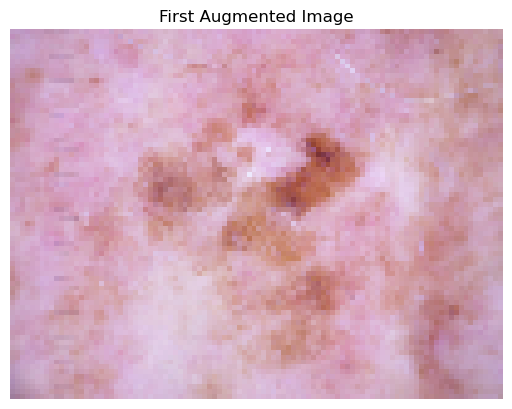

Original number of images: 4423
Number of augmented images: 8846
Total number of images: 13269


In [13]:
# Perform augmentation and append to the lists
for i in range(len(X)):
    img = X[i]
    img_gray = X_gray[i]
    label = y[i]

    # Append the original image and label
    X_aug.append(img)
    X_gray_aug.append(img_gray)
    y_aug.append(label)

    # Create augmented versions and append
    for _ in range(2):  # Create 2 augmented versions of each image
        img_aug = seq.augment_image(img)
        img_gray_aug = cv2.cvtColor(img_aug, cv2.COLOR_BGR2GRAY)

        X_aug.append(img_aug)
        X_gray_aug.append(img_gray_aug)
        y_aug.append(label)

# Convert lists to numpy arrays
X_aug = np.array(X_aug)
X_gray_aug = np.array(X_gray_aug)
y_aug = np.array(y_aug)

# Display the first augmented image using matplotlib
plt.imshow(cv2.cvtColor(X_aug[0], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title('First Augmented Image')
plt.axis('off')  # Hide axis
plt.show()

# Print the number of original and augmented images
print("Original number of images:", len(X))
print("Number of augmented images:", len(X_aug) - len(X))
print("Total number of images:", len(X_aug))

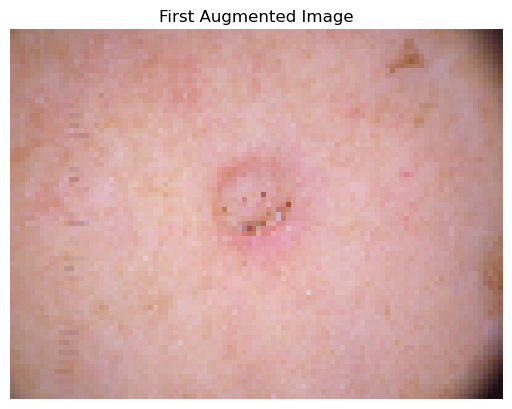

In [22]:
plt.imshow(cv2.cvtColor(X[7], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title('First Augmented Image')
plt.axis('off')  # Hide axis
plt.show()

## Testing K-NN Classifier

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=101)
X_gray_train, X_gray_test, y_train, y_test = train_test_split(X_gray_aug, y_aug, test_size=0.2, random_state=101)

knn = KNeighborsClassifier(n_neighbors=5)

X_g_train_flat = X_gray_train.reshape(X_gray_train.shape[0],-1)
X_g_test_flat = X_gray_test.reshape(X_gray_test.shape[0],-1)
print (X_g_train_flat.shape)
print (X_g_test_flat.shape)

knn.fit(X_g_train_flat, y_train)

(10615, 7500)
(2654, 7500)


KNeighborsClassifier()

In [25]:
def model_stats(name, y_test, y_pred, y_pred_proba):
  cm = confusion_matrix(y_test, y_pred)

  print(name)

  accuracy = accuracy_score(y_test,y_pred)
  print ("The accuracy of the model is " + str(round(accuracy,5)))

  roc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

  print ("The ROC AUC Score of the model is " + str(round(roc_score,5)))

  return cm

In [27]:
y_pred = knn.predict(X_g_test_flat)
y_pred_proba = knn.predict_proba(X_g_test_flat)

knn_cm = model_stats("K Nearest Neighbors Gray",y_test,y_pred,y_pred_proba)

K Nearest Neighbors Gray
The accuracy of the model is 0.38885
The ROC AUC Score of the model is 0.65548


In [28]:
def plot_cm(name, cm):
  classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

  df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
  df_cm = df_cm.round(5)

  plt.figure(figsize = (12,8))
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title(name + " Model Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

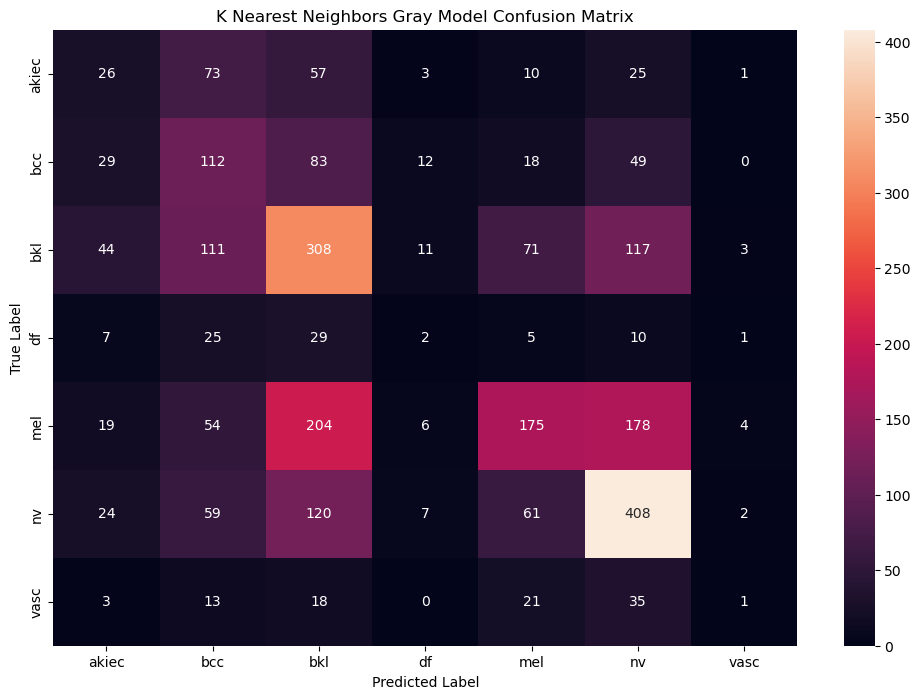

In [29]:
plot_cm("K Nearest Neighbors Gray",knn_cm)

In [31]:
X_gray_test, X_gray_val, y_g_test, y_g_val = train_test_split(X_gray_test, y_test, test_size=0.5, random_state=101)

X_gray_test_flat = np.reshape(X_gray_test,(X_gray_test.shape[0],X_gray_test.shape[1]*X_gray_test.shape[2]))
X_gray_val_flat = np.reshape(X_gray_val,(X_gray_val.shape[0],X_gray_val.shape[1]*X_gray_val.shape[2]))

In [34]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [2, 3],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

knn = KNeighborsClassifier()

# Using StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Initialize GridSearchCV with reduced parallel jobs
gs_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, verbose=1, n_jobs=2)

# Fit the model using a subset of the data (if necessary)
subset_size = 1000  # adjust as necessary
X_subset = X_g_train_flat[:subset_size]
y_subset = y_train[:subset_size]

gs_knn.fit(X_subset.astype(np.float32), y_subset.astype(np.float32))

# Print the best parameters and the best score
print("Best parameters found: ", gs_knn.best_params_)
print("Best cross-validation score: ", gs_knn.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score:  0.321


In [35]:
y_pred = gs_knn.predict(X_g_test_flat)
y_pred_proba = gs_knn.predict_proba(X_g_test_flat)

knn_cm = model_stats("K Nearest Neighbors Gray",y_test,y_pred,y_pred_proba)

K Nearest Neighbors Gray
The accuracy of the model is 0.31575
The ROC AUC Score of the model is 0.58335
